<a href="https://colab.research.google.com/github/s1c5000/kaggle/blob/main/Titanic/3_2_Titanic_Top4__with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

캐글 필사3
* 원본 : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [ ]:
# kaggle json
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 21.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.04MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 23.7MB/s]


1.introduction

2. Load and check data

* 2.1 load data
* 2.2 Outlier detection
* 2.3 joining train and test set
* 2.4 check for null and missing values

3 Feature analysis
* 3.1 Numerical values
* 3.2 categorical values

4 Filling missing values
* 4.1 Age

5 Feature engineering
* 5.1 Name/Title
* 5.2 Family Size
* 5.3 Cabin
* 5.4 Ticket

6 Modeling
* 6.1 Simple Modeling
** 6.1.1 cross validation model
** 6.1.2 Hyperparamater tunning for best models
** 6.1.3 plot learning curves
** 6.1.4 feature importance of the tree based
* 6.2 Ensemble modeling
** 6.2.1 combining models
* 6.3 prediction
** 6.3.1 predic and submit results


# 1. introduction
타이타닉 컴피티션을 선택한 이유는 feature engineering과 ensemble modleing을 설명하기 좋다고 생각했기 때문입니다.

첫번째로 몇가지 feature에 대해 분석을 해보고 feature engineering에 집중하겠습니다. 마지막은 voting을 사용하여 Survived를 예측하는 것 입니다.

메인파트는
* Feature analysis
* Feature Engineering
* Modeling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

plt.style.use('seaborn')
sns.set(style='white', context='notebook', palette='deep', font_scale=2)

# 2. Load and check data


## 2.1 Load data


In [ ]:
train=pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

In [ ]:
def detect_outliers(df, n, features):
  # 리스트로 변환
  outlier_indices = []

  for col in features:
    # 1st quartile(25%)
    Q1 = np.percentile(df[col],25)
    # 3rd quartile 75%
    Q3 = np.percentile(df[col], 75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    # 특정 col에 대해 outlire를 찾는다.
    outlier_list_col = df[(df[col] < Q1- outlier_step) | (df[col] > Q1 + outlier_step)].index
    outlier_indices.extend(outlier_list_col)

  print(outlier_indices)
  # 2(n) 개 이상의 이상치를 같는 index선택
  outlier_indices = Counter(outlier_indices) # 요서별 개수를 새서 dict로 반환
  print(type(outlier_indices))
  print(outlier_indices)

  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
  print(multiple_outliers) # 이상치가 2(n)개 이상인 인덱스
  return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

[7, 16, 24, 27, 38, 48, 50, 59, 63, 68, 69, 71, 85, 88, 104, 119, 120, 147, 159, 164, 171, 176, 180, 182, 183, 201, 229, 233, 245, 261, 266, 278, 301, 311, 324, 330, 333, 341, 374, 386, 392, 409, 436, 437, 448, 469, 480, 485, 529, 541, 542, 565, 571, 600, 618, 634, 642, 644, 655, 660, 665, 683, 686, 726, 742, 787, 792, 813, 819, 824, 846, 850, 860, 863, 7, 8, 10, 13, 16, 24, 25, 27, 43, 50, 54, 58, 59, 63, 65, 68, 71, 78, 86, 88, 93, 97, 98, 102, 118, 119, 124, 128, 136, 140, 145, 147, 148, 153, 155, 159, 160, 164, 165, 166, 167, 171, 172, 175, 176, 180, 182, 183, 184, 188, 193, 197, 201, 205, 229, 233, 237, 247, 248, 251, 254, 255, 259, 261, 262, 266, 268, 272, 273, 278, 279, 297, 299, 305, 311, 312, 314, 318, 319, 323, 324, 328, 329, 332, 340, 341, 348, 352, 356, 360, 362, 374, 377, 381, 386, 390, 394, 407, 409, 416, 417, 419, 423, 424, 435, 436, 437, 438, 440, 445, 446, 448, 450, 469, 472, 479, 480, 485, 489, 498, 506, 523, 529, 530, 532, 533, 535, 539, 540, 541, 542, 548, 549, 550,

이상치 값은 예측에 극적인 영향을 미칠 수 있으므로(특히 회귀에서) 이를 관리하기로 했습니다

분포값 (IQR)의 1사분위와 3사분위 사이로 구성된 사분위서 범위를 정의하는 Outliers를 탐지했습니다. 

수치형 변수 (Age, SibSp, Sarch, Fare)에서 이상  값을 감지하기로 했습니다. 최소한 2개의 이상치값이 있는 인덱스를 제외시킬 인댁스로 구분했습니다

In [ ]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.000,C23 C25 C27,S
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.900,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.900,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.000,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.550,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.550,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.550,NaN,S
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.550,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.000,C23 C25 C27,S


이상치 10개를 감지합니다 28, 82, 342 승객의 요금이 높습니다. 나머지 7개는 sibSp가 매우 높습니다

In [ ]:
train.loc[[26, 27, 28],:] # 27행은 이상치때문에 사라질 것이다

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


In [ ]:
# drop outliers
train= train.drop(Outliers_to_drop, axis=0).reset_index(drop=True) # 인덱스 초기화
train.loc[[26,27,28],:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
27,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
28,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S


## 2.3 joining train and test set

In [ ]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

categorical 변수의 변환을 위해 train과 test를 합쳤다

## 2.4 check for null and missing values

In [ ]:
# np.nan으로결측치 채우기
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1002
Embarked          2
dtype: int64

Age 및 cabin feature은 결측값의 중요한 부분을 가지고 있습니다.
Survived는 테스트엔 없어서 결측치로 나온다


In [ ]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  874 non-null    int64  
 1   Survived     874 non-null    int64  
 2   Pclass       874 non-null    int64  
 3   Name         874 non-null    object 
 4   Sex          874 non-null    object 
 5   Age          704 non-null    float64
 6   SibSp        874 non-null    int64  
 7   Parch        874 non-null    int64  
 8   Ticket       874 non-null    object 
 9   Fare         874 non-null    float64
 10  Cabin        199 non-null    object 
 11  Embarked     872 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.1+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          675
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,874.000000,874.000000,874.000000,874,874,704.000000,874.000000,874.000000,874,874.000000,199,872
unique,NaN,NaN,NaN,874,2,NaN,NaN,NaN,679,NaN,146,3
top,NaN,NaN,NaN,"Mionoff, Mr. Stoytcho",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,568,NaN,NaN,NaN,7,NaN,4,629
mean,447.157895,0.386728,2.306636,NaN,NaN,29.899389,0.425629,0.350114,NaN,30.502116,NaN,NaN
std,256.625628,0.487279,0.834413,NaN,NaN,14.508944,0.800677,0.781271,NaN,46.880544,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,226.250000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,448.500000,0.000000,3.000000,NaN,NaN,28.250000,0.000000,0.000000,NaN,14.054150,NaN,NaN
75%,667.750000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,30.000000,NaN,NaN


# 3. Feature analysis(피쳐분석)

## 3.1 Numerical Values

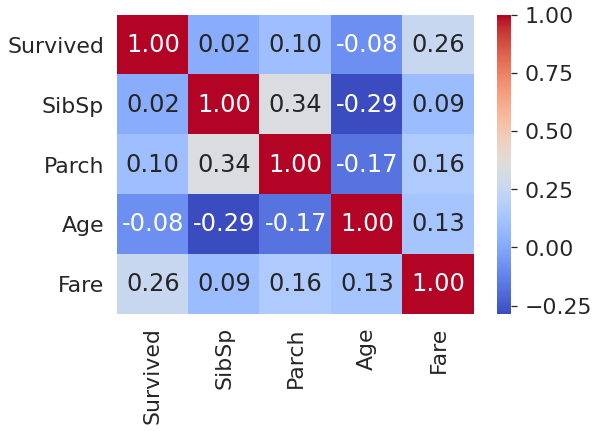

In [ ]:
# 수치형 변수들의 상관관계
sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,
            fmt='.2f', cmap='coolwarm')

Fare만 생존 확률과 의미있는 상관 관계를 갖습니다.

다른 기능이 유용하지 않는다는 의미는 아닙니다. 이러한 기능의 하위 집단은 생존과 상관관계가 있을 수 있습니다. 이를 확인하려면 이러한 기능을 자세히 살펴봐야합니다.

### SibSp


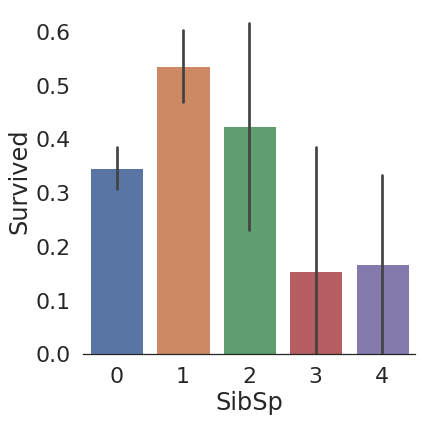

In [ ]:
sns.factorplot('SibSp', 'Survived', data = train, kind='bar', size = 6)
sns.despine(left=True)

형제 자매/ 배우자가 많은 승객은 생존하기 어렵습니다

단일 승객 또는 두사람과 함께 있을경우 생존가능성이 더 높습니다.

이 관찰은 매우 흥미롭습니다 이러한 범주를 설명하는 새로운 기능을고려할 수 있습니다

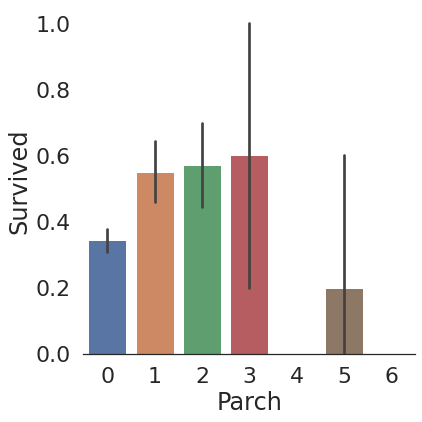

In [ ]:
sns.factorplot('Parch','Survived', data = train, size=6, kind='bar')
sns.despine(left=True)

소규모 가족은 독신(Parch 0) 중형(Parch 3,4) 및 대가족(Parch 5,6)보다 생존 할 기회가 더 많습니다. Parch가 3명인 승객의 생존율에는 표준 편차가 큼으로 주의하십시오

### Age

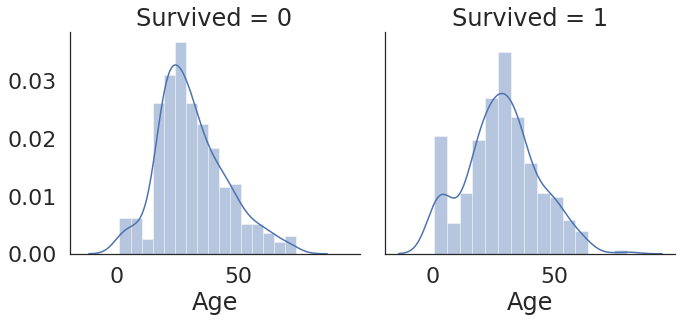

In [ ]:
g = sns.FacetGrid(train, col='Survived', height=5)
g.map(sns.distplot, 'Age')

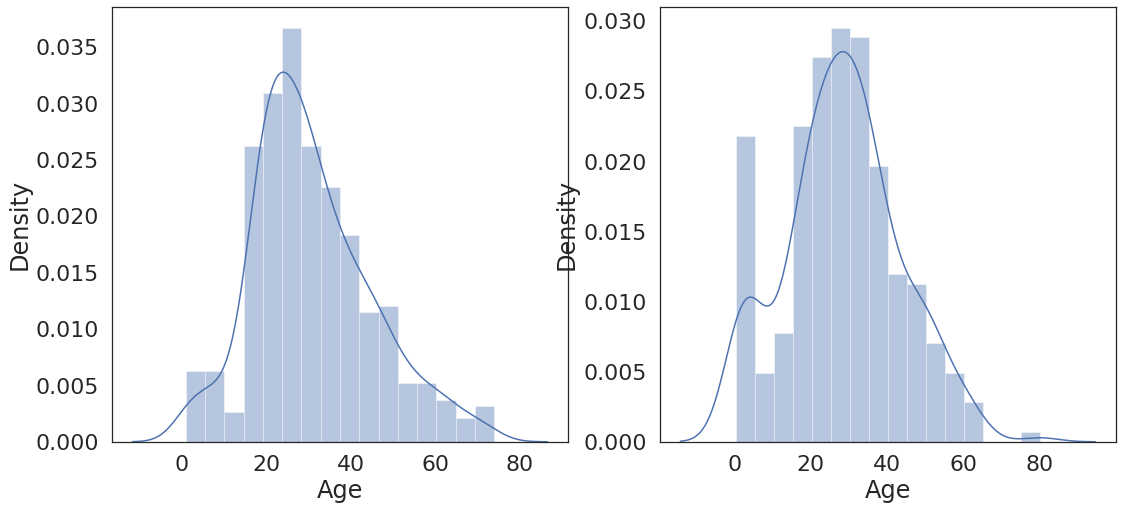

In [ ]:
# 위와 같지만 subplot으로 그린것
f, ax = plt.subplots(1,2, figsize=(18,8))
sns.distplot(train[train['Survived']==0]['Age'], bins= 16, ax=ax[0])
sns.distplot(train[train['Survived']==1]['Age'], bins=16, ax=ax[1])

나이가 어린 승객의 생존율이 높습니다

Age가 Survived와 관련이 없더라도 생존가능성이 어느정도있는 승객의 연령 범주가 있음을 알 수있습니다.

아주 어린 승객이 생존할 기회가 더 많은 것 같습니다

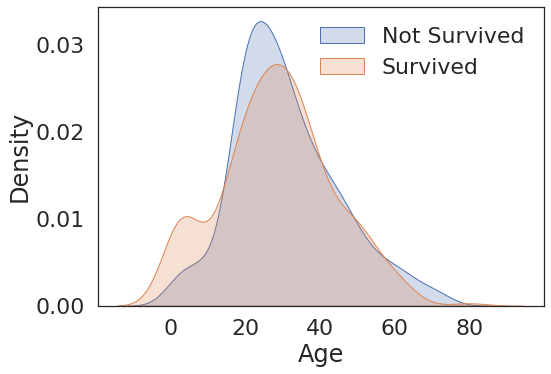

In [ ]:
g=sns.kdeplot(train[train['Survived']==0]['Age'], shade=True)
g=sns.kdeplot(train[train['Survived']==1]['Age'], shade=True)
g.legend(['Not Survived', 'Survived'])

두 그래프를 중첩하면 아주 어린 아이들은 생존율이 높은 걸 확연하게 볼 수 있다.

### Fare

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())


누락된 값이 하나있으므로 예측에 중요한 영향을 미치지 않는 중앙값으로 채우겠다

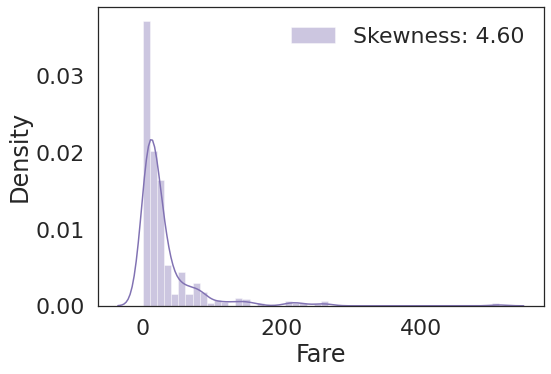

In [ ]:
# Explore Fare distribution
# Skewness : 왜곡
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best') # 위치 적절히 표시


보다시피 Fare의 분포는 매우 왜곡 되어있습니다. 이로인해 크기가 조정되더라도 모델에서 매우 높은 값이 지나치게 높아 질 수 있습니다.

이 경우 왜곡을 줄이기 위해 log 함수로 변환하는 것이좋습니다

In [ ]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

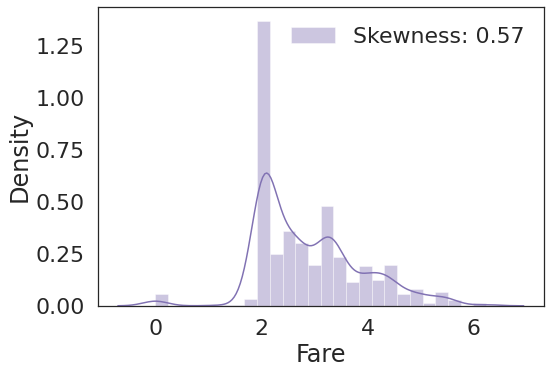

In [ ]:
# Explore Fare distribution
# Skewness : 왜곡
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best') # 위치 적

왜곡이 많이 감소하였다

### Sex

Text(0, 0.5, 'Survival Probability')

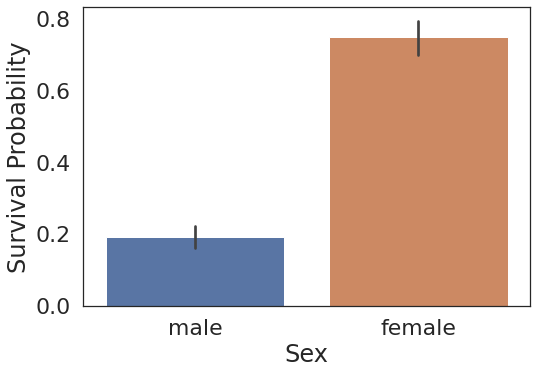

In [ ]:
g = sns.barplot('Sex', 'Survived', data=train)
g.set_ylabel('Survival Probability')

In [ ]:
train[['Sex','Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.748366
male,0.191901


남성이 여성보다 생존 할 기회가 적다는 것은 분명합니다.      
따라서 Sex는 생존 예측에 중요한 역할을 할 수 있습니다

### Pclass

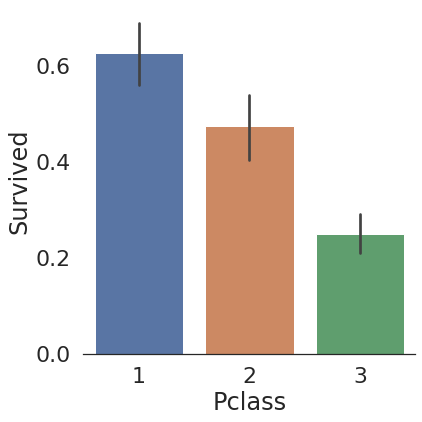

In [ ]:
sns.factorplot('Pclass','Survived', data=train, kind='bar', size=6)
sns.despine(left=True)

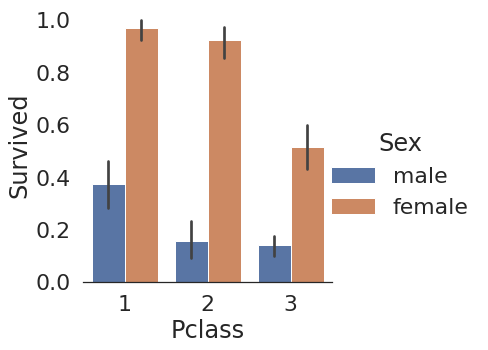

In [ ]:
sns.factorplot('Pclass','Survived',data=train, kind='bar', hue='Sex')
sns.despine(left=True)

1등석 승객은 2등석, 3등석 승객보다 생존 기회가 더 많습니다.

이 추세는 남성 승객과 여성 성객 모두를 볼때 보존됩니다

### Embarked

In [ ]:
dataset['Embarked'].isnull().sum()

2

In [ ]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

누랄된 값이 2개이므로 가장 빈번한 S 값으로 넣겠습니다.

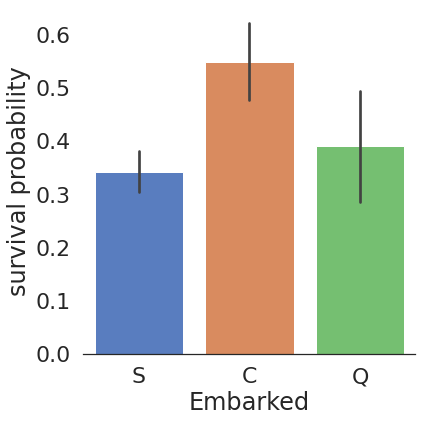

In [ ]:
# Explore Embarked vs Survived 
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

(C)에서 오는 승객이 생존 할 기회가 더 많은 것 같습니다.

내 가설은 퀸스 타운 (Q), 사우스 햄튼 (S)보다 셰르 부르에서 온 승객의 일등석 승객 비율이 더 높다는 것입니다.

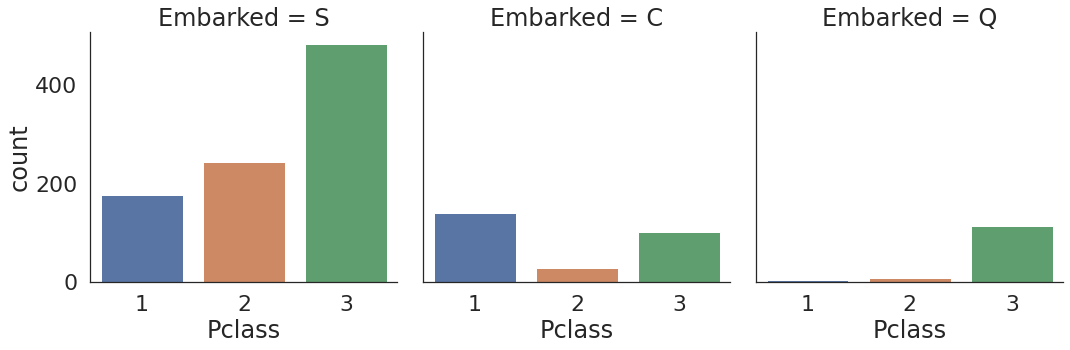

In [ ]:
sns.factorplot('Pclass', col='Embarked', data=dataset, kind= 'count')

실제로 3 등석은 사우스 햄튼 (S)과 퀸스 타운 (Q)에서 오는 승객에게 가장 빈번한 반면, Cherbourg 승객은 대부분 생존율이 가장 높은 1 등석입니다.

이 시점에서는 왜 일등석이 생존율이 더 높은지 설명 할 수 없습니다. 내 가설은 일등석 승객의 영향으로 인해 대피 중에 우선 순위가 지정되었다는 것입니다.

# 4. Filling missing Value

## 4.1 Age
보다시피 Age열에는 전체 데이터 세트에서 256개의 누락된 값이 있습니다.

생존 가능성이 더 놏은 하위 집단(예: 어린이)이 있기때문에 연령 특성을 유지하고 결측값을 대치하는 것이 좋습니다.

이 문제를 해결하기위해 Age(Sex, Parch, Pclass, SibSp)와 가장 관련있는 기능을 살펴보았습니다

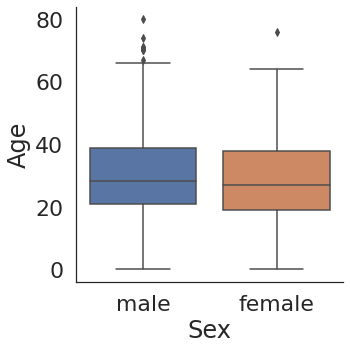

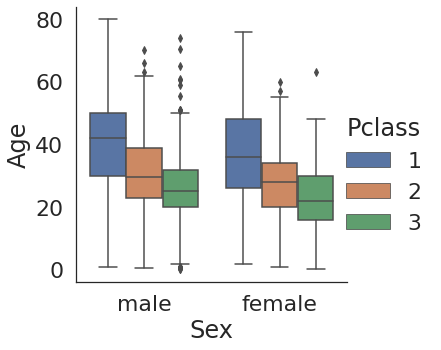

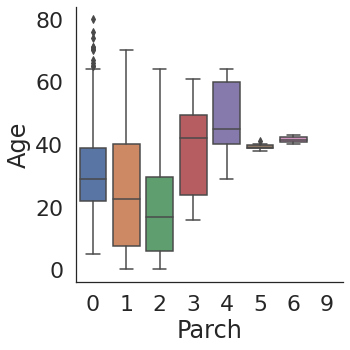

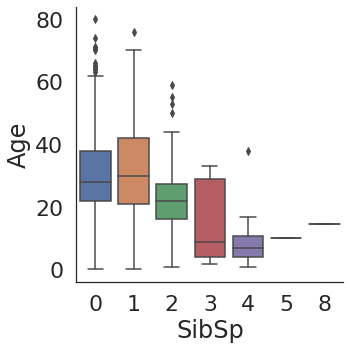

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

연령 분포는 남성과 여성 하위 집단에서 동일한 것으로 보이므로 성별은 연령을 예측하는 데 도움이되지 않습니다.

Pclass는 1등석이 가장 나이가 많고 그 다음이 2등석, 3등석 순입니다

또한 승객이 부모 / 자녀가 많을수록 나이가 많고 동생 / 배우자가 많을수록 젊습니다.

In [ ]:
# Sex의 카테고리값을 0, 1로 바꾼다
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

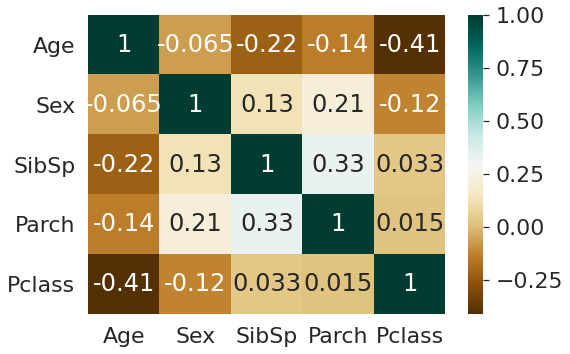

In [ ]:
sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot=True)

나이는 성별과 상관이 없지만 Pclass, Parch 및 SibSp와 음의 상관 관계가 있습니다.

누락 된 Age를 위해 SibSP, Parch 및 Pclass를 사용하기로 결정했습니다.

전략은 Pclass, Parch 및 SibSp에 따라 비슷한 행의 중간 연령으로 Age를 채우는 것입니다.

In [ ]:
index_NaN_age= list(dataset['Age'][dataset['Age'].isnull()].index)
print(index_NaN_age)
for i in index_NaN_age:
  age_med = dataset['Age'].median()
  # 각 조건마다 인덱스가 True, False로 나온다.
  # Age가 결측치인 행의 (SibSp 가 같은 행, Parch가 같은행, Pclass가 같은행)을 
  # 교집합으로 찾아서 Age의 평균을 낸다.
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) &
                             (dataset['Parch'] == dataset.iloc[i]['SibSp']) &
                             (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med


[5, 17, 19, 26, 27, 28, 30, 31, 35, 41, 44, 45, 46, 47, 54, 62, 63, 73, 74, 79, 84, 91, 97, 103, 105, 117, 122, 124, 136, 150, 154, 161, 163, 171, 175, 179, 180, 190, 192, 207, 216, 222, 228, 233, 234, 243, 249, 253, 257, 263, 267, 270, 277, 288, 291, 293, 294, 296, 297, 299, 321, 325, 326, 337, 341, 344, 348, 349, 354, 357, 358, 365, 374, 377, 398, 399, 400, 402, 404, 409, 414, 417, 420, 433, 440, 443, 446, 448, 453, 455, 457, 459, 464, 469, 473, 478, 483, 485, 490, 495, 499, 505, 510, 512, 515, 519, 521, 526, 535, 540, 545, 548, 551, 552, 556, 561, 566, 572, 577, 581, 584, 586, 589, 590, 599, 600, 601, 617, 621, 627, 631, 636, 638, 641, 644, 655, 657, 662, 668, 679, 684, 696, 698, 705, 714, 719, 725, 726, 727, 746, 752, 754, 759, 762, 764, 769, 776, 778, 800, 810, 811, 813, 817, 822, 824, 833, 843, 851, 861, 871, 884, 896, 903, 907, 910, 913, 915, 921, 928, 932, 939, 950, 957, 958, 959, 962, 965, 967, 976, 981, 982, 985, 990, 995, 998, 1001, 1006, 1007, 1020, 1022, 1025, 1034, 1037, 

In [ ]:
# 5행의 Age는 결측치이다. 다른 조건들을 교집합으로 모은 뒤 중앙값으로 결측치를 정해줄 것이다
i =5 
dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))]

2       26.0
4       35.0
5       25.0
12      20.0
14      14.0
        ... 
1284    25.0
1286    28.0
1287    25.0
1289    38.5
1290    25.0
Name: Age, Length: 472, dtype: float64

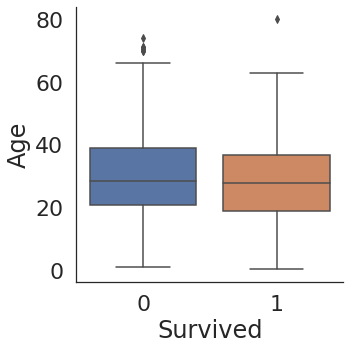

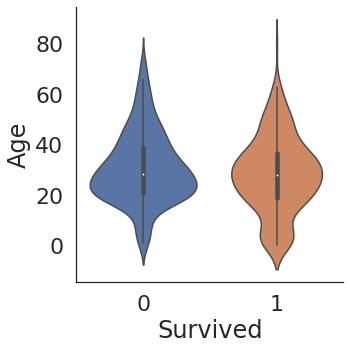

In [ ]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

생존 한 부분 집단과 생존하지 않은 부분 집단에서 연령의 중앙값 사이에는 차이가 없습니다.

그러나 살아남은 승객의 바이올린에서 우리는 여전히 아주 어린 승객이 생존율이 더 높다는 것을 알 수 있습니다.

# 5. Feature Engineering

## 5.1 Name/Title

In [ ]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
# 이름의 타이틀을 얻는다.
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

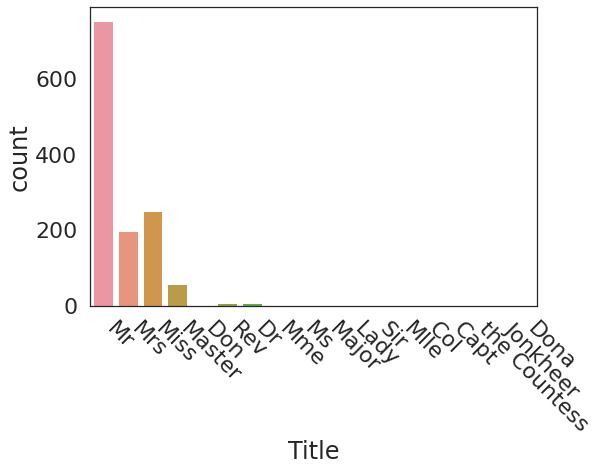

In [ ]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=-45, ha='left') 

데이터 세트에는 17 개의 제목이 있으며 대부분은 매우 드물며 4 개의 카테고리로 그룹화 할 수 있습니다.

In [ ]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess',
                                             'Capt', 'Col','Don', 'Dr', 'Major',
                                             'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                        "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

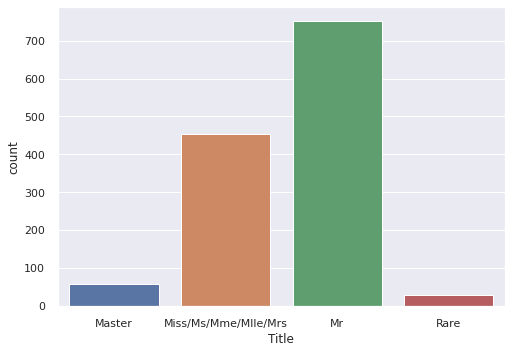

In [ ]:
sns.set(font_scale=1)
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

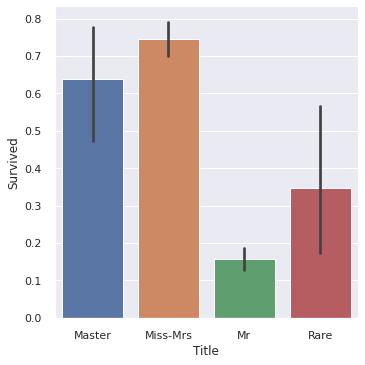

In [ ]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])

"여성과 어린이 우선"

희귀 한 칭호를 가진 승객이 생존 할 기회가 더 많다는 점이 흥미 롭습니다.

In [ ]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

## 5.2 Family size

대가족이 대피하는 동안 자매 / 형제 / 부모를 찾아 대피하는 데 더 많은 어려움을 겪을 것이라고 상상할 수 있습니다. 그래서 저는 SibSp, Parch 및 1 (승객 포함)의 합인 "Fize"(가족 크기) 기능을 만들기로 선택했습니다.

In [ ]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1 # 1은 자신

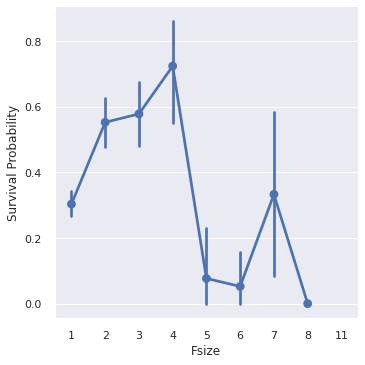

In [ ]:
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

가족 규모가 중요한 역할을하는 것으로 보이며 대가족의 경우 생존 확률이 가장 낮습니다.

또한 가족 규모의 4 가지 범주를 만들기로 결정했습니다.

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

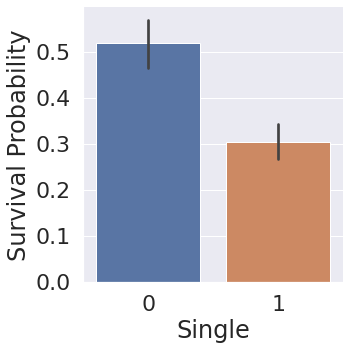

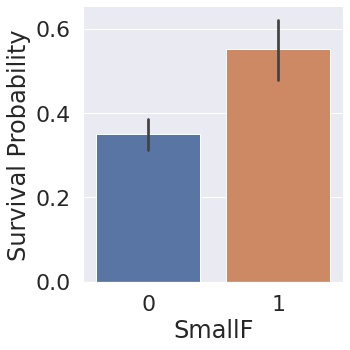

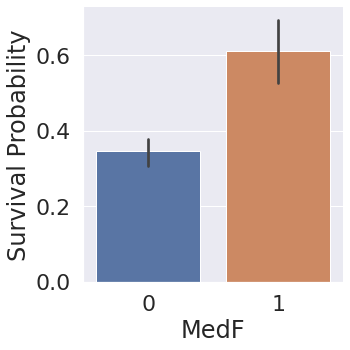

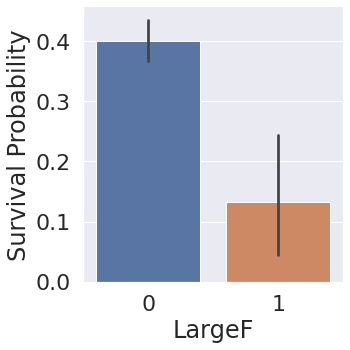

In [ ]:
sns.set(font_scale=2)
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

중소 가족이 1 인 승객 및 대가족보다 생존 할 기회가 더 많다는 것을 보여줍니다.

In [ ]:
# title과 embarked는 문자형이므로 모델에 넣기위해선 수치형으로 바꿔줘야한다
# get_dummies는 one hot encoding해준다.
# prefix는 one hot encoding시에 나눠진 column앞에붙는 이름
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


22개의 feature를 갖고있습니다

## 5.3 Cabin


In [ ]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].describe()

count     290
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset["Cabin"].isnull().sum()

1002

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Cabin의 결측치를 X 로 한다
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

객실의 첫 글자는 데스크를 나타내며, 타이타닉에서 승객의 가능한 위치를 나타 내기 때문에이 정보 만 유지하기로 선택했습니다.

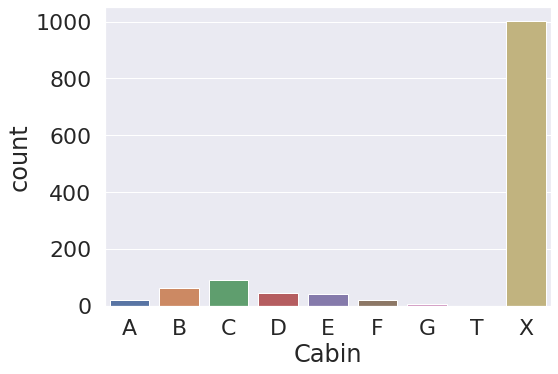

In [ ]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

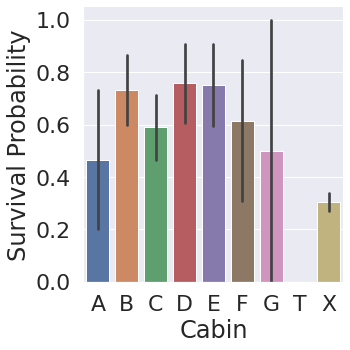

In [ ]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

일반적으로 객실이있는 승객이 (X)가없는 승객보다 생존 가능성이 더 높다는 것을 알 수 있습니다.

특히 객실 B, C, D, E 및 F에 해당됩니다.

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

## 5.4 Ticket

In [ ]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

이는 동일한 접두사를 공유하는 티켓이 함께 배치 된 객실에 대해 예약 될 수 있음을 의미 할 수 있습니다. 따라서 선박 내 선실의 실제 배치로 이어질 수 있습니다.

동일한 접두사가있는 티켓은 비슷한 등급과 생존율을 가질 수 있습니다.

그래서 티켓 기능 열을 티켓 접두사로 바꾸기로 결정했습니다. 더 유익 할 수 있습니다.

In [ ]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() : # 접두사가 있다면
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T") # onehot_encoding

Pclass도 변경해 보겠습니다.

In [ ]:
dataset.Pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [ ]:
dataset["Pclass"] = dataset["Pclass"].astype("category") # 타입을 category값으로 한다.

In [ ]:
dataset.Pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: category
Categories (3, int64): [1, 2, 3]

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [ ]:
# 쓸모없는 Feature 삭제
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
len(dataset.columns.tolist())

67

# 6. Modeling

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace = True)

In [ ]:
train['Survived'] = train['Survived'].astype(int)
Y_train= train['Survived']
X_train=train.drop(labels=['Survived'],axis=1)

## 6.1 simple modeling

### 6.1.1 cross validate models

10개의 인기있는 분류기를 비교하여 계층화된 kfold교차검증 절차를 통해 각각의 평균 정확도를 평가했습니다.

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis


In [ ]:
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# modeling
random_state= 123
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

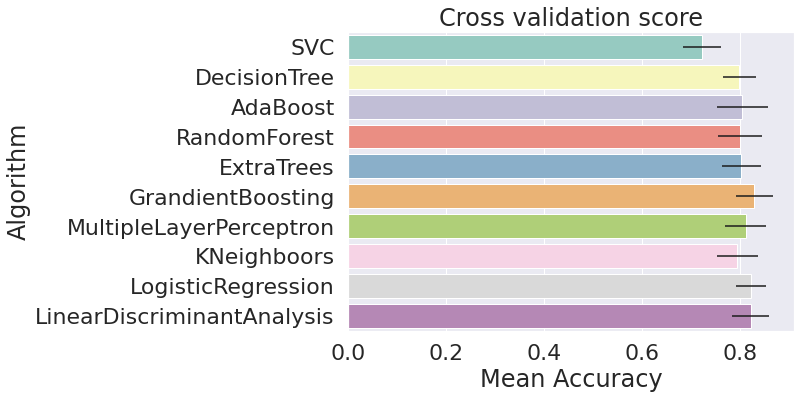

In [ ]:
cv_results=[] # 각10개의 모델별로 10(kfold)개의 accuracy가 들어간다
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, 
                                    scoring='accuracy', cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means,
                       'CrossValerrors': cv_std,
                       'Algorithm':['SVC','DecisionTree','AdaBoost',
                                    'RandomForest', 'ExtraTrees','GrandientBoosting',
                                    'MultipleLayerPerceptron','KNeighboors',
                                    'LogisticRegression','LinearDiscriminantAnalysis']})

g=sns.barplot('CrossValMeans','Algorithm', data=cv_res, palette='Set3', 
              orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g=g.set_title('Cross validation score')

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees 및 GradientBoosting 분류기를 선택하기로 결정했습니다.

### 6.1.2 Hyperparameter tunning for best models

AdaBoost, ExtraTrees, RandomForest, GradientBoosting 및 SVC 분류기에 대한 grid search를 하겠습니다

이 단계는 오랜 시간이 걸립니다.

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, 
                        scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:   12.4s finished


In [ ]:
gsadaDTC.best_score_

0.8147335423197491

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, 
                      scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.0min finished


0.8295323928944617

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


0.8318443051201673

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.4min finished


0.8353187042842215

In [ ]:
# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.3min finished


0.8295454545454545

### 6.1.3 Plot learning curves
학습 곡선은 훈련 세트에 대한 과적 합 효과와 정확도에 대한 훈련 크기의 영향을 확인하는 좋은 방법입니다.

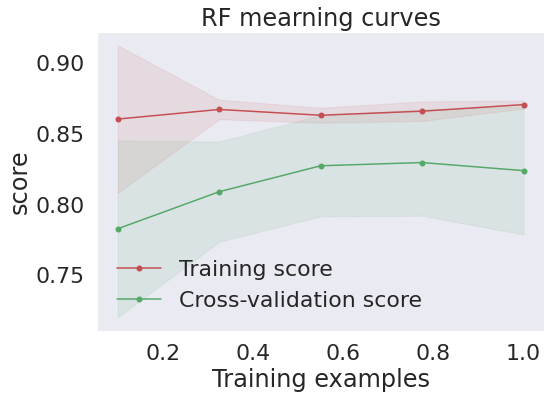

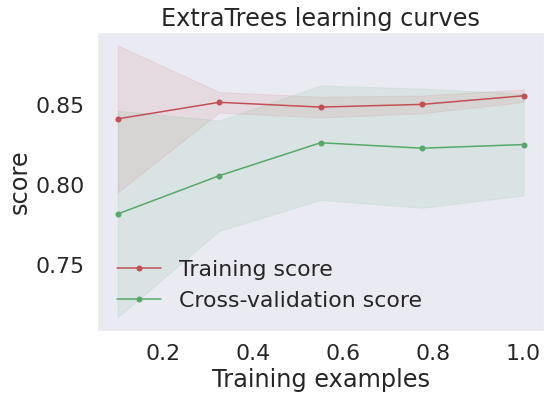

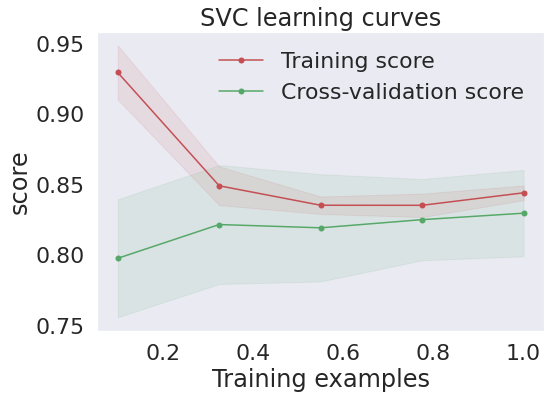

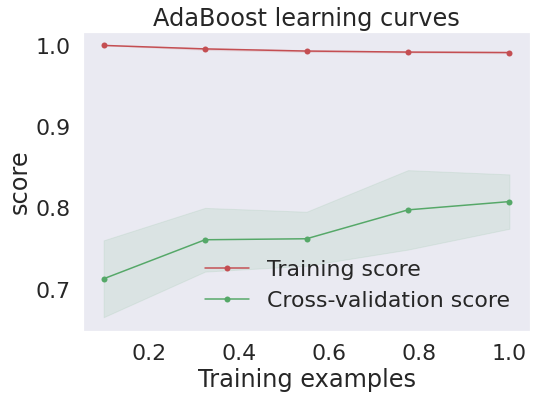

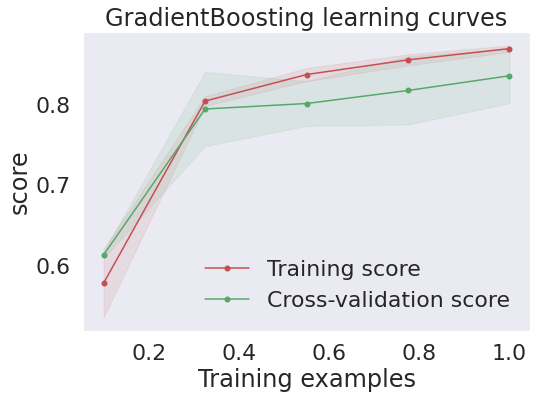

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1,
                        train_sizes = np.linspace(.1, 1.0, 5)):
  # training, test의 학습곡선의 간단한 plot을 생성
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel('Training examples')
  plt.ylabel('score')
  # 각 모델의 best_estimator_로 학습
  train_size, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  # 선 주위의 흐릿한 색상 칠함
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1, color='r')
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color='g')
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

  plt.legend(loc='best')
  return plt

g= plot_learning_curve(gsRFC.best_estimator_,'RF mearning curves', X_train, Y_train,cv=kfold)
g= plot_learning_curve(gsExtC.best_estimator_,'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g= plot_learning_curve(gsSVMC.best_estimator_,'SVC learning curves', X_train, Y_train, cv=kfold)
g= plot_learning_curve(gsadaDTC.best_estimator_,'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g= plot_learning_curve(gsGBC.best_estimator_,'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

GradientBoosting 및 Adaboost 분류기는 훈련 세트를 과도하게 맞추는 경향이 있습니다. 증가하는 교차 검증 곡선에 따르면 GradientBoosting과 Adaboost는 더 많은 훈련 예제를 통해 더 잘 수행 할 수 있습니다.

SVC 및 ExtraTrees 분류기는 훈련 및 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것 같습니다.

### 6.1.4 Tree based Model의 feature importance

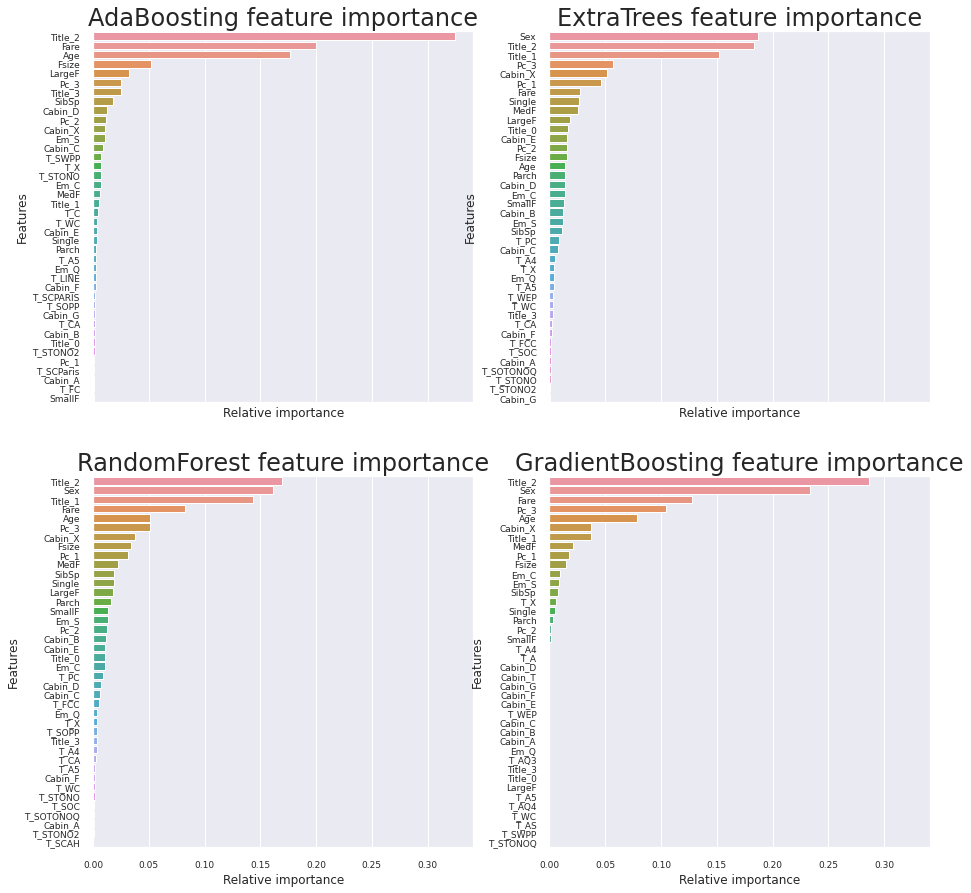

In [ ]:
nrows = ncols =2
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees',ExtC_best),
                     ('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
  for col in range(ncols):
    name=names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g= sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40],
                   orient='h', ax= axes[row][col])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

4 개의 분류기는 상대적 중요도에 따라 상위 기능이 다릅니다. 이는 예측이 동일한 기능을 기반으로하지 않음을 의미합니다. 그럼에도 불구하고 '요금', 'Title_2', 'Age'및 'Sex'와 같이 분류에 대한 몇 가지 공통된 중요한 기능을 공유합니다.

Mrs / Mlle / Mme / Miss / Ms 범주를 나타내는 Title_2는 성별과 높은 상관 관계가 있습니다.

Pc_1, Pc_2, Pc_3 및 요금은 승객의 일반적인 사회적 지위를 나타냅니다.

성별 및 Title_2 (Mrs / Mlle / Mme / Miss / Ms) 및 Title_3 (Mr)은 성별을 나타냅니다.

Age 및 Title_1 (마스터)은 승객의 연령을 나타냅니다.

Fsize, LargeF, MedF, Single은 승객 가족의 규모를 나타냅니다.



이 4 가지 분류기의 기능 중요성에 따르면 생존 예측은 보트의 위치보다 승객의 연령, 성별, 가족 규모 및 사회적 지위와 더 관련이있는 것으로 보입니다.


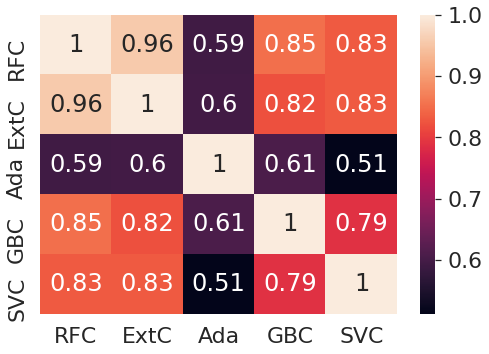

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

Adaboost가 다른 분류기와 비교되는 경우를 제외하고는 5 개의 분류기에서 예측이 매우 유사 해 보입니다.

5 개의 분류기는 어느 정도 동일한 예측을 제공하지만 약간의 차이가 있습니다. 5 개의 분류기 예측 간의 이러한 차이점은 앙상블 투표를 고려하기에 충분합니다.

## 6.2 Ensemble modeling


### 6.2.1 모델 합치기

5 개의 분류기에서 나오는 예측을 결합하기 위해 voting classifier를 선택했습니다.

나는 각 투표의 확률을 고려하기 위해 투표 매개 변수에 "soft"인수를 전달하겠습니다

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction

### 6.3.1 Predict and submit results

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)